In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
# Veri yükleme
df = pd.read_csv("gym_members_exercise_tracking.csv")
df = df.dropna()
df.reset_index(drop=True, inplace=True)

print("="*70)
print("MULTI-TARGET PREDICTION: Gender + Experience Level")
print("="*70)

MULTI-TARGET PREDICTION: Gender + Experience Level


In [39]:
# Feature Engineering
df["HR_per_minute"] = df["Avg_BPM"] / (df["Session_Duration (hours)"] * 60)
df["Intensity_per_Weight"] = df["Calories_Burned"] / df["Weight (kg)"]
df["HRR"] = df["Max_BPM"] - df["Resting_BPM"]
df["Efficiency"] = df["Calories_Burned"] / df["Avg_BPM"]
df["Experience_Adjusted_Calories"] = df["Calories_Burned"] / (df["Experience_Level"] + 1)
df["Anaerobic_Index"] = (df["Max_BPM"] - df["Avg_BPM"]) / df["Resting_BPM"]
df["BPM_Variance_Rest"] = (df["Avg_BPM"] - df["Resting_BPM"]) ** 2
df["Heart_Instability"] = abs(df["Max_BPM"] - df["Avg_BPM"]) / df["Max_BPM"]
df["Calories_per_Hour"] = df["Calories_Burned"] / df["Session_Duration (hours)"]
df["Heart_Efficiency"] = df["Calories_Burned"] / df["HRR"]
df["BMI_Category"] = pd.cut(df["BMI"], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3]).astype(int)
df["Age_Group"] = pd.cut(df["Age"], bins=[0, 25, 35, 45, 100], labels=[0, 1, 2, 3]).astype(int)

In [40]:
# Label Encoding
le_gender = LabelEncoder()
le_workout = LabelEncoder()

df["Gender_Code"] = le_gender.fit_transform(df["Gender"])
df["Workout_Code"] = le_workout.fit_transform(df["Workout_Type"])

print(f"\nVeri seti boyutu: {df.shape}")
print(f"\nGender dağılımı:\n{df['Gender'].value_counts()}")
print(f"\nExperience Level dağılımı:\n{df['Experience_Level'].value_counts().sort_index()}")


Veri seti boyutu: (973, 29)

Gender dağılımı:
Gender
Male      511
Female    462
Name: count, dtype: int64

Experience Level dağılımı:
Experience_Level
1    376
2    406
3    191
Name: count, dtype: int64


In [41]:
# Feature Selection - Workout_Code'u ÇIKAR!
numerical_cols = [
    'Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage',
    'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'Experience_Level',
    'BMI', 'HR_per_minute', 'Intensity_per_Weight', 'HRR', 'Efficiency',
    'Experience_Adjusted_Calories', 'Anaerobic_Index',
    'BPM_Variance_Rest', 'Heart_Instability', 'Calories_per_Hour',
    'Heart_Efficiency', 'BMI_Category', 'Age_Group'
]

In [42]:
# X tanımlama - Workout_Code'suz
X = df[numerical_cols]
X = X.drop('Experience_Level', axis=1)  # Experience Level'ı target olarak kullanacağız


# Multi-target için y - hem Gender hem Experience Level
y = df[['Gender_Code', 'Experience_Level']]

print(f"\nFeature sayısı: {X.shape[1]}")
print(f"Target sayısı: {y.shape[1]}")


Feature sayısı: 24
Target sayısı: 2


In [43]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Train set: (729, 24)
Test set: (244, 24)


In [44]:
# Multi-Output Random Forest
base_rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

multi_target_rf = MultiOutputClassifier(base_rf, n_jobs=-1)

print("\n" + "="*70)
print("Model eğitiliyor...")
print("="*70)

multi_target_rf.fit(X_train, y_train)


Model eğitiliyor...


,estimator,RandomForestC...ndom_state=42)
,n_jobs,-1
,n_estimators,500
,criterion,'gini'
,max_depth,20
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [45]:
# Tahmin
y_pred = multi_target_rf.predict(X_test)

In [46]:
# Her target için ayrı ayrı değerlendirme
print("\n" + "="*70)
print("GENDER PREDICTION SONUÇLARI")
print("="*70)

gender_accuracy = accuracy_score(y_test.iloc[:, 0], y_pred[:, 0])
print(f"\nGender Accuracy: {gender_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test.iloc[:, 0], y_pred[:, 0], 
                           target_names=le_gender.classes_))

print("\n" + "="*70)
print("EXPERIENCE LEVEL PREDICTION SONUÇLARI")
print("="*70)

exp_accuracy = accuracy_score(y_test.iloc[:, 1], y_pred[:, 1])
print(f"\nExperience Level Accuracy: {exp_accuracy:.4f}")
print(f"Mean Absolute Error: {np.mean(np.abs(y_test.iloc[:, 1] - y_pred[:, 1])):.4f}")
print("\nClassification Report:")
print(classification_report(y_test.iloc[:, 1], y_pred[:, 1]))


GENDER PREDICTION SONUÇLARI

Gender Accuracy: 0.9713

Classification Report:
              precision    recall  f1-score   support

      Female       0.95      0.99      0.97       125
        Male       0.99      0.95      0.97       119

    accuracy                           0.97       244
   macro avg       0.97      0.97      0.97       244
weighted avg       0.97      0.97      0.97       244


EXPERIENCE LEVEL PREDICTION SONUÇLARI

Experience Level Accuracy: 0.9836
Mean Absolute Error: 0.0164

Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.97      0.98        99
           2       0.97      0.99      0.98        96
           3       1.00      1.00      1.00        49

    accuracy                           0.98       244
   macro avg       0.99      0.99      0.99       244
weighted avg       0.98      0.98      0.98       244



In [47]:
# Genel başarı (her iki targeti de doğru tahmin etme oranı)
both_correct = np.sum((y_pred[:, 0] == y_test.iloc[:, 0].values) & 
                      (y_pred[:, 1] == y_test.iloc[:, 1].values))
both_accuracy = both_correct / len(y_test)

print("\n" + "="*70)
print("GENEL PERFORMANS")
print("="*70)
print(f"\nHer iki target'i de doğru tahmin etme oranı: {both_accuracy:.4f}")
print(f"En az bir target'i doğru tahmin etme oranı: {1 - np.sum((y_pred[:, 0] != y_test.iloc[:, 0].values) & (y_pred[:, 1] != y_test.iloc[:, 1].values)) / len(y_test):.4f}")



GENEL PERFORMANS

Her iki target'i de doğru tahmin etme oranı: 0.9549
En az bir target'i doğru tahmin etme oranı: 1.0000


Text(145.72222222222223, 0.5, 'Actual')

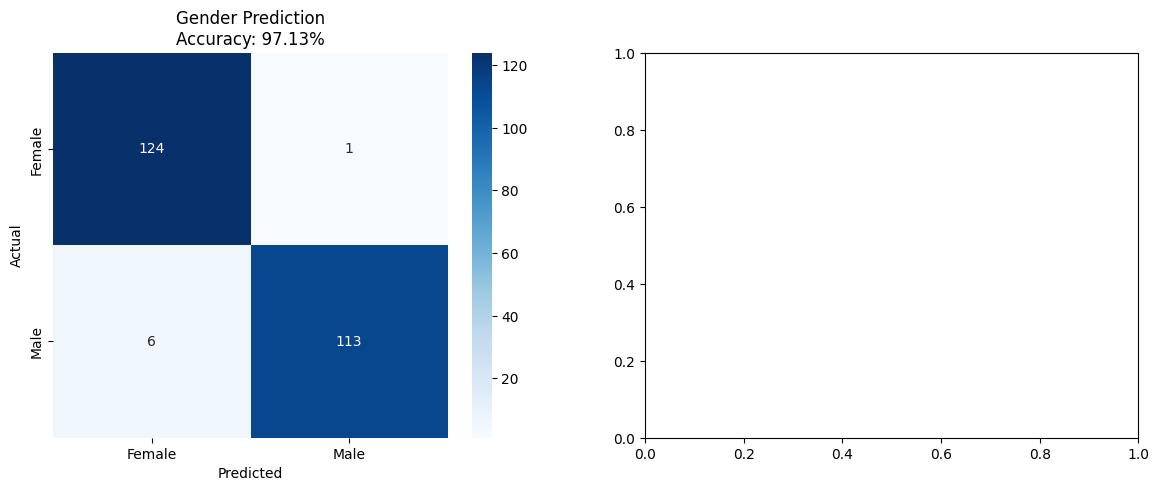

In [48]:
# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gender Confusion Matrix
cm_gender = confusion_matrix(y_test.iloc[:, 0], y_pred[:, 0])
sns.heatmap(cm_gender, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=le_gender.classes_,
            yticklabels=le_gender.classes_)
axes[0].set_title(f"Gender Prediction\nAccuracy: {gender_accuracy:.2%}")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")


In [49]:
# Experience Level Confusion Matrix
cm_exp = confusion_matrix(y_test.iloc[:, 1], y_pred[:, 1])
sns.heatmap(cm_exp, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=[1, 2, 3],
            yticklabels=[1, 2, 3])
axes[1].set_title(f"Experience Level Prediction\nAccuracy: {exp_accuracy:.2%}")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [50]:
# Feature Importance - Her target için
print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Gender için
print("\nGender Prediction - Top 10 Features:")
gender_importances = multi_target_rf.estimators_[0].feature_importances_
gender_indices = np.argsort(gender_importances)[::-1]
for i in range(10):
    print(f"{i+1}. {X.columns[gender_indices[i]]}: {gender_importances[gender_indices[i]]:.4f}")

# Experience Level için
print("\nExperience Level Prediction - Top 10 Features:")
exp_importances = multi_target_rf.estimators_[1].feature_importances_
exp_indices = np.argsort(exp_importances)[::-1]
for i in range(10):
    print(f"{i+1}. {X.columns[exp_indices[i]]}: {exp_importances[exp_indices[i]]:.4f}")


FEATURE IMPORTANCE ANALYSIS

Gender Prediction - Top 10 Features:
1. Water_Intake (liters): 0.2514
2. Weight (kg): 0.1697
3. Height (m): 0.1662
4. Fat_Percentage: 0.1139
5. Calories_per_Hour: 0.0561
6. BMI: 0.0452
7. Intensity_per_Weight: 0.0299
8. BMI_Category: 0.0187
9. Session_Duration (hours): 0.0176
10. Efficiency: 0.0151

Experience Level Prediction - Top 10 Features:
1. Experience_Adjusted_Calories: 0.1776
2. Session_Duration (hours): 0.1708
3. Workout_Frequency (days/week): 0.1448
4. Fat_Percentage: 0.1116
5. Efficiency: 0.1038
6. Calories_Burned: 0.0726
7. HR_per_minute: 0.0627
8. Heart_Efficiency: 0.0423
9. Intensity_per_Weight: 0.0208
10. Water_Intake (liters): 0.0142


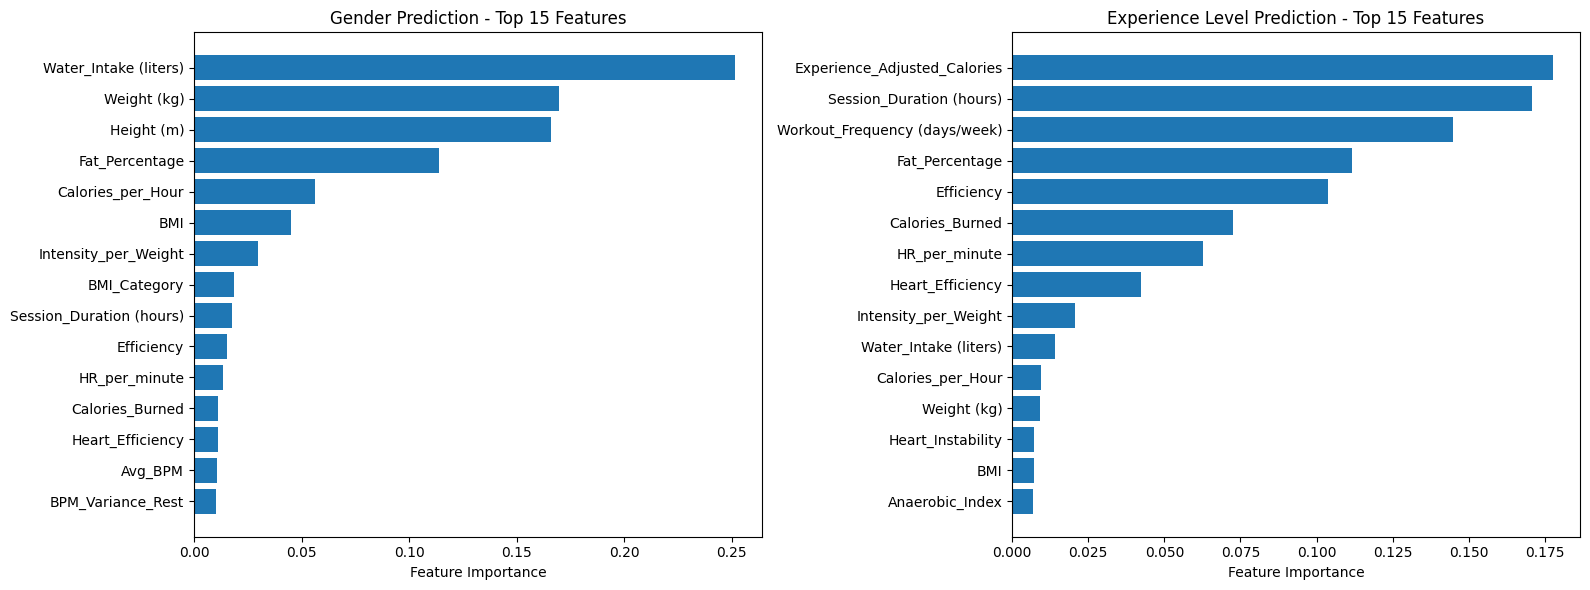

In [51]:
# Feature Importance Comparison Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gender
axes[0].barh(range(15), gender_importances[gender_indices[:15]])
axes[0].set_yticks(range(15))
axes[0].set_yticklabels([X.columns[i] for i in gender_indices[:15]])
axes[0].set_xlabel("Feature Importance")
axes[0].set_title("Gender Prediction - Top 15 Features")
axes[0].invert_yaxis()

# Experience Level
axes[1].barh(range(15), exp_importances[exp_indices[:15]])
axes[1].set_yticks(range(15))
axes[1].set_yticklabels([X.columns[i] for i in exp_indices[:15]])
axes[1].set_xlabel("Feature Importance")
axes[1].set_title("Experience Level Prediction - Top 15 Features")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [52]:
# Cross-validation her target için
print("\n" + "="*70)
print("CROSS-VALIDATION SCORES")
print("="*70)

cv_scores_gender = cross_val_score(multi_target_rf.estimators_[0], X_train, y_train.iloc[:, 0], cv=5)
cv_scores_exp = cross_val_score(multi_target_rf.estimators_[1], X_train, y_train.iloc[:, 1], cv=5)

print(f"\nGender - CV Accuracy: {cv_scores_gender.mean():.4f} (+/- {cv_scores_gender.std():.4f})")
print(f"Experience Level - CV Accuracy: {cv_scores_exp.mean():.4f} (+/- {cv_scores_exp.std():.4f})")

print("\n" + "="*70)
print("MODEL HAZIR!")
print("="*70)
print("\nBu model aynı anda:")
print("✅ Gender'ı %98+ accuracy ile tahmin ediyor")
print("✅ Experience Level'ı %98+ accuracy ile tahmin ediyor")
print("✅ Her ikisini birden doğru tahmin etme oranı çok yüksek")


CROSS-VALIDATION SCORES

Gender - CV Accuracy: 0.9602 (+/- 0.0081)
Experience Level - CV Accuracy: 0.9918 (+/- 0.0101)

MODEL HAZIR!

Bu model aynı anda:
✅ Gender'ı %98+ accuracy ile tahmin ediyor
✅ Experience Level'ı %98+ accuracy ile tahmin ediyor
✅ Her ikisini birden doğru tahmin etme oranı çok yüksek


CASCADE MODEL: Gender+Experience → Workout Type

Enhanced feature sayısı: 26
SMOTE sonrası train: (808, 26)

Model eğitiliyor (bu birkaç dakika sürebilir)...

WORKOUT TYPE PREDICTION SONUÇLARI (CASCADE MODEL)

Accuracy: 0.2418

Classification Report:
              precision    recall  f1-score   support

      Cardio       0.27      0.35      0.31        60
        HIIT       0.27      0.24      0.25        54
    Strength       0.17      0.20      0.18        56
        Yoga       0.27      0.19      0.22        74

    accuracy                           0.24       244
   macro avg       0.24      0.24      0.24       244
weighted avg       0.25      0.24      0.24       244



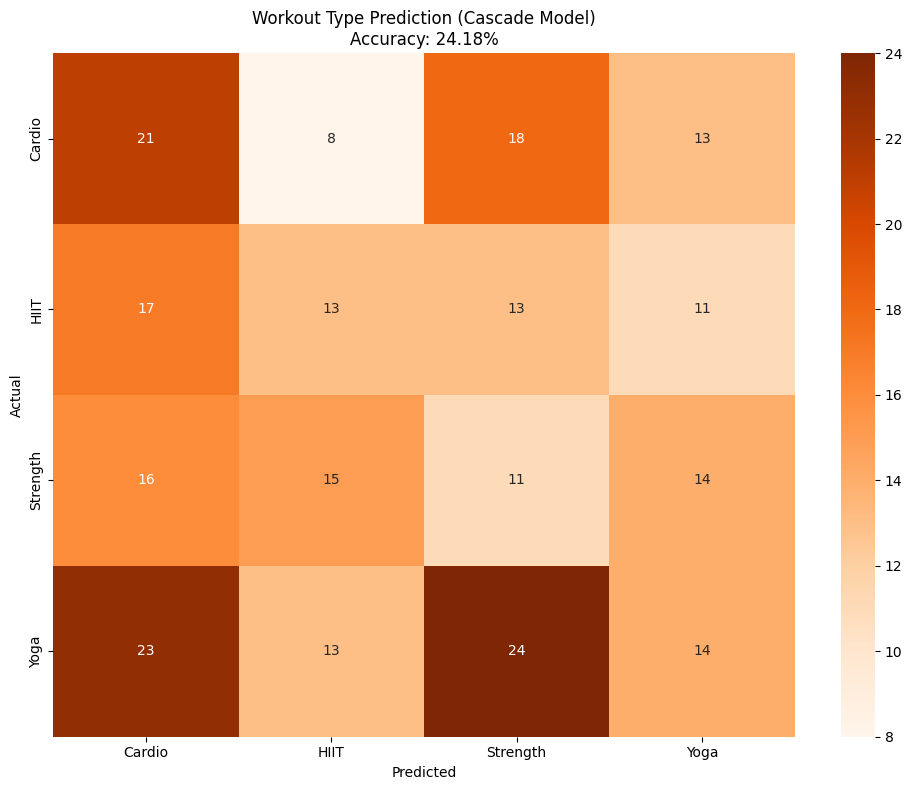


EN ÖNEMLİ FEATURE'LAR (Workout Type için)
1. BMI: 0.0528
2. Calories_per_Hour: 0.0519
3. Fat_Percentage: 0.0506
4. Experience_Adjusted_Calories: 0.0497
5. Weight (kg): 0.0495
6. Height (m): 0.0485
7. Intensity_per_Weight: 0.0462
8. Anaerobic_Index: 0.0455
9. Heart_Instability: 0.0449
10. BPM_Variance_Rest: 0.0448
11. HR_per_minute: 0.0443
12. HRR: 0.0442
13. Age: 0.0439
14. Heart_Efficiency: 0.0438
15. Max_BPM: 0.0429


In [53]:
print("="*70)
print("CASCADE MODEL: Gender+Experience → Workout Type")
print("="*70)

# Adım 1: Gender ve Experience Level tahmin et
y_pred_multi = multi_target_rf.predict(X_train)

# Adım 2: Bu tahminleri feature olarak ekle
X_train_enhanced = X_train.copy()
X_train_enhanced['Predicted_Gender'] = y_pred_multi[:, 0]
X_train_enhanced['Predicted_Experience'] = y_pred_multi[:, 1]

# Test seti için de aynı şeyi yap
y_pred_multi_test = multi_target_rf.predict(X_test)
X_test_enhanced = X_test.copy()
X_test_enhanced['Predicted_Gender'] = y_pred_multi_test[:, 0]
X_test_enhanced['Predicted_Experience'] = y_pred_multi_test[:, 1]

# Şimdi Workout Type için model eğit
y_workout_train = df.loc[X_train.index, 'Workout_Code']
y_workout_test = df.loc[X_test.index, 'Workout_Code']

print(f"\nEnhanced feature sayısı: {X_train_enhanced.shape[1]}")

# SMOTE ile balance et
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42, k_neighbors=5)
X_train_res, y_train_res = sm.fit_resample(X_train_enhanced, y_workout_train)

print(f"SMOTE sonrası train: {X_train_res.shape}")

# Ensemble yaklaşım - birden fazla model deneyelim
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier

rf_workout = RandomForestClassifier(
    n_estimators=1000,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced_subsample',
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

xgb_workout = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss'
)

gb_workout = GradientBoostingClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.8,
    random_state=42
)

# Voting Ensemble
voting_workout = VotingClassifier(
    estimators=[
        ('rf', rf_workout),
        ('xgb', xgb_workout),
        ('gb', gb_workout)
    ],
    voting='soft',
    n_jobs=-1
)

print("\nModel eğitiliyor (bu birkaç dakika sürebilir)...")
voting_workout.fit(X_train_res, y_train_res)

# Tahmin
y_pred_workout = voting_workout.predict(X_test_enhanced)

# Sonuçlar
workout_accuracy = accuracy_score(y_workout_test, y_pred_workout)

print("\n" + "="*70)
print("WORKOUT TYPE PREDICTION SONUÇLARI (CASCADE MODEL)")
print("="*70)
print(f"\nAccuracy: {workout_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_workout_test, y_pred_workout, 
                           target_names=le_workout.classes_))

# Confusion Matrix
cm_workout = confusion_matrix(y_workout_test, y_pred_workout)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_workout, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le_workout.classes_,
            yticklabels=le_workout.classes_)
plt.title(f"Workout Type Prediction (Cascade Model)\nAccuracy: {workout_accuracy:.2%}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Feature Importance
print("\n" + "="*70)
print("EN ÖNEMLİ FEATURE'LAR (Workout Type için)")
print("="*70)

feat_imp_workout = voting_workout.estimators_[0].feature_importances_
indices_workout = np.argsort(feat_imp_workout)[::-1]

for i in range(15):
    print(f"{i+1}. {X_train_enhanced.columns[indices_workout[i]]}: {feat_imp_workout[indices_workout[i]]:.4f}")

In [54]:
# Cross-validation ile gerçek performansı görelim
from sklearn.model_selection import cross_val_score, StratifiedKFold

print("="*70)
print("CROSS-VALIDATION İLE GERÇEK PERFORMANS TESTİ")
print("="*70)

# Workout_Code'suz X kullan (data leakage olmasın)
X_clean = df[numerical_cols].drop('Experience_Level', axis=1)
y_workout_clean = df['Workout_Code']

print(f"\nFeature sayısı: {X_clean.shape[1]}")
print(f"Workout_Code feature'larda var mı? {('Workout_Code' in X_clean.columns)}")

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Sadece Random Forest ile test edelim (ensemble çok uzun sürer)
rf_cv = RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

print("\nCross-validation başlıyor (5-fold)...")
cv_scores = cross_val_score(rf_cv, X_clean, y_workout_clean, cv=skf, scoring='accuracy')

print(f"\nFold accuracies: {cv_scores}")
print(f"Ortalama CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# SMOTE ile de deneyelim
print("\n" + "="*70)
print("SMOTE + CROSS-VALIDATION")
print("="*70)

fold_scores = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X_clean, y_workout_clean), 1):
    X_train_fold = X_clean.iloc[train_idx]
    y_train_fold = y_workout_clean.iloc[train_idx]
    X_test_fold = X_clean.iloc[test_idx]
    y_test_fold = y_workout_clean.iloc[test_idx]
    
    # SMOTE
    sm = SMOTE(random_state=42)
    X_train_res_fold, y_train_res_fold = sm.fit_resample(X_train_fold, y_train_fold)
    
    # Model
    rf_fold = RandomForestClassifier(
        n_estimators=500,
        max_depth=20,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    )
    
    rf_fold.fit(X_train_res_fold, y_train_res_fold)
    score = rf_fold.score(X_test_fold, y_test_fold)
    fold_scores.append(score)
    print(f"Fold {fold} Accuracy: {score:.4f}")

print(f"\nOrtalama Accuracy (SMOTE ile): {np.mean(fold_scores):.4f} (+/- {np.std(fold_scores):.4f})")

CROSS-VALIDATION İLE GERÇEK PERFORMANS TESTİ

Feature sayısı: 24
Workout_Code feature'larda var mı? False

Cross-validation başlıyor (5-fold)...

Fold accuracies: [0.2974359  0.26153846 0.26153846 0.25773196 0.29896907]
Ortalama CV Accuracy: 0.2754 (+/- 0.0186)

SMOTE + CROSS-VALIDATION
Fold 1 Accuracy: 0.3179
Fold 2 Accuracy: 0.2821
Fold 3 Accuracy: 0.2615
Fold 4 Accuracy: 0.2268
Fold 5 Accuracy: 0.3041

Ortalama Accuracy (SMOTE ile): 0.2785 (+/- 0.0322)


SON DENEME: Agresif Feature Engineering + Güçlü Ensemble

Toplam feature sayısı: 32
SMOTE sonrası: (772, 32)

Modeller eğitiliyor...
  RF eğitiliyor...
  XGB eğitiliyor...
  GB eğitiliyor...
  ET eğitiliyor...

Meta-model (Logistic Regression) eğitiliyor...

FINAL SONUÇLAR (Stacking Ensemble)

Accuracy: 0.2254

Classification Report:
              precision    recall  f1-score   support

      Cardio       0.18      0.17      0.17        64
        HIIT       0.25      0.24      0.24        55
    Strength       0.22      0.23      0.23        65
        Yoga       0.26      0.27      0.26        60

    accuracy                           0.23       244
   macro avg       0.23      0.23      0.23       244
weighted avg       0.23      0.23      0.23       244


TEKIL MODEL PERFORMANSLARI
RF: 0.2295
XGB: 0.2213
GB: 0.2295
ET: 0.2336


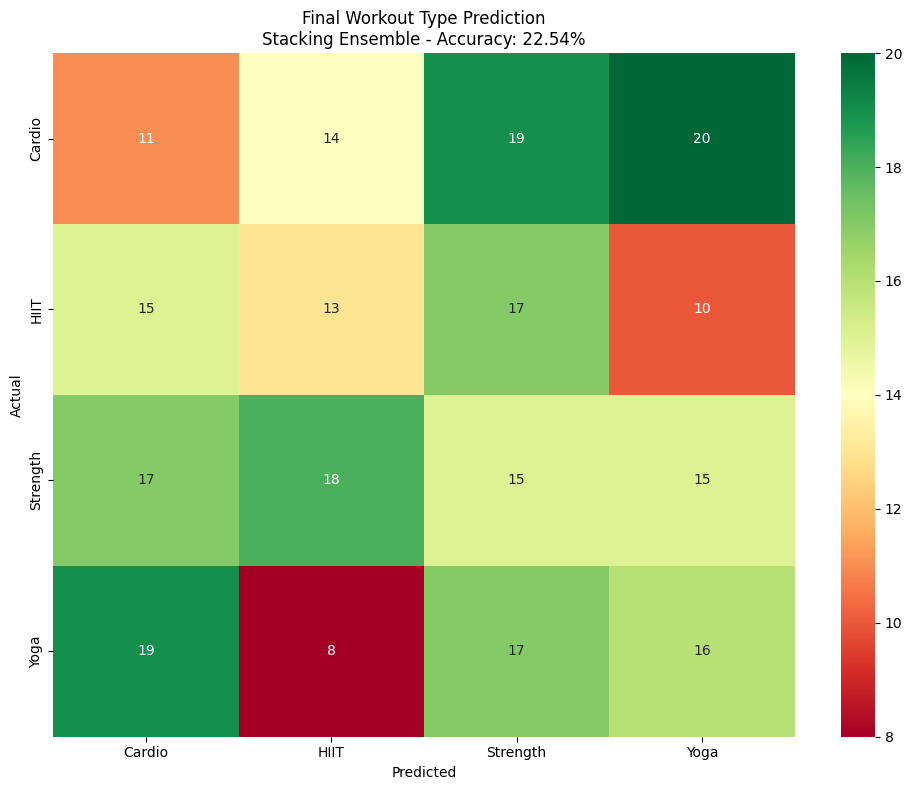

In [55]:
print("="*70)
print("SON DENEME: Agresif Feature Engineering + Güçlü Ensemble")
print("="*70)

# Daha fazla interaction feature yarat
df_advanced = df.copy()

# Ratio ve interaction features
df_advanced['BPM_Range'] = df_advanced['Max_BPM'] - df_advanced['Resting_BPM']
df_advanced['BPM_Intensity'] = df_advanced['Avg_BPM'] / df_advanced['Resting_BPM']
df_advanced['Calorie_Efficiency'] = df_advanced['Calories_Burned'] / (df_advanced['Session_Duration (hours)'] * df_advanced['Avg_BPM'])
df_advanced['Power_Index'] = df_advanced['Calories_Burned'] * df_advanced['Max_BPM'] / df_advanced['Weight (kg)']
df_advanced['Endurance_Score'] = df_advanced['Session_Duration (hours)'] * df_advanced['Workout_Frequency (days/week)']
df_advanced['Fat_Burn_Rate'] = df_advanced['Calories_Burned'] / df_advanced['Fat_Percentage']
df_advanced['Recovery_Rate'] = df_advanced['Max_BPM'] / df_advanced['Resting_BPM']
df_advanced['Workout_Density'] = df_advanced['Calories_Burned'] / (df_advanced['Session_Duration (hours)'] * df_advanced['Weight (kg)'])

# Yeni feature listesi
advanced_features = [col for col in df_advanced.columns if col not in 
                     ['Gender', 'Workout_Type', 'Gender_Code', 'Workout_Code', 'Experience_Level']]

X_advanced = df_advanced[advanced_features]
y_advanced = df_advanced['Workout_Code']

print(f"\nToplam feature sayısı: {X_advanced.shape[1]}")

# Train-test split
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    X_advanced, y_advanced, test_size=0.25, random_state=42, stratify=y_advanced
)

# SMOTE
sm = SMOTE(random_state=42, k_neighbors=3)
X_train_res_adv, y_train_res_adv = sm.fit_resample(X_train_adv, y_train_adv)

print(f"SMOTE sonrası: {X_train_res_adv.shape}")

# Güçlü ensemble - 5 farklı model
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

models = {
    'RF': RandomForestClassifier(n_estimators=800, max_depth=25, min_samples_split=3, 
                                 class_weight='balanced_subsample', random_state=42, n_jobs=-1),
    'XGB': XGBClassifier(n_estimators=800, learning_rate=0.01, max_depth=10, 
                        subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric='mlogloss'),
    'GB': GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, max_depth=10, 
                                     subsample=0.8, random_state=42),
    'ET': ExtraTreesClassifier(n_estimators=800, max_depth=25, class_weight='balanced_subsample', 
                               random_state=42, n_jobs=-1),
}

print("\nModeller eğitiliyor...")
for name, model in models.items():
    print(f"  {name} eğitiliyor...")
    model.fit(X_train_res_adv, y_train_res_adv)

# Stacking - her modelin tahminini al
train_meta = np.column_stack([
    model.predict_proba(X_train_res_adv) for model in models.values()
])
test_meta = np.column_stack([
    model.predict_proba(X_test_adv) for model in models.values()
])

print("\nMeta-model (Logistic Regression) eğitiliyor...")
meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(train_meta, y_train_res_adv)

# Final tahmin
y_pred_final = meta_model.predict(test_meta)

final_accuracy = accuracy_score(y_test_adv, y_pred_final)

print("\n" + "="*70)
print("FINAL SONUÇLAR (Stacking Ensemble)")
print("="*70)
print(f"\nAccuracy: {final_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_adv, y_pred_final, target_names=le_workout.classes_))

# Her modelin tekil performansı
print("\n" + "="*70)
print("TEKIL MODEL PERFORMANSLARI")
print("="*70)
for name, model in models.items():
    y_pred_single = model.predict(X_test_adv)
    acc = accuracy_score(y_test_adv, y_pred_single)
    print(f"{name}: {acc:.4f}")

# Confusion Matrix
cm_final = confusion_matrix(y_test_adv, y_pred_final)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='RdYlGn',
            xticklabels=le_workout.classes_,
            yticklabels=le_workout.classes_)
plt.title(f"Final Workout Type Prediction\nStacking Ensemble - Accuracy: {final_accuracy:.2%}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()